In [ ]:
# --- Wgp+LS CycleGAN ---

# Packages
import cv2

import csv

from google.colab import drive
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

import multiprocessing

import numpy as np

import os

import pandas as pd

from pathlib import Path

from PIL import Image

import shutil

from skimage import data
from skimage import filters
from skimage.measure import label
from skimage.util import img_as_ubyte
from skimage.metrics import structural_similarity as ssim

from tempfile import NamedTemporaryFile

import tensorflow as tf
from keras import backend as K

import torch
from torch import nn
from torchsummary import summary
import torch.nn.functional as foo
from torch.utils.data import Subset
import torchvision.datasets as dset
import torch.utils.data as torchdata
import torchvision.transforms as transforms

from tqdm import tqdm

drive.mount('/content/drive')

path_img='/content/drive/My Drive/Images/'
path_b='/content/drive/My Drive/batches/'
path_models='/content/drive/My Drive/models/'
path_opt='/content/drive/My Drive/optimizers/'

#% matplotlib inline
torch.cuda.empty_cache()


# CLASSES

# Generators

class ResBlock(nn.Module):
  # Transformation layers
  def __init__(self, f):
    super(ResBlock, self).__init__()
    self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), nn.InstanceNorm2d(f), nn.ReLU(),
                              nn.Conv2d(f, f, 3, 1, 1))
    self.norm = nn.InstanceNorm2d(f)

  def forward(self, x):
    return foo.relu(self.norm(self.conv(x) + x))

class Generator(nn.Module):
  def __init__(self, f=64, blocks=9):
    super(Generator, self).__init__()
    layers = [nn.ReflectionPad2d(3),
              nn.Conv2d(1, f, 7, 1, 0), nn.InstanceNorm2d(f), nn.ReLU(True),
              nn.Conv2d(f, 2 * f, 3, 2, 1), nn.InstanceNorm2d(2 * f), nn.ReLU(True),
              nn.Conv2d(2 * f, 4 * f, 3, 2, 1), nn.InstanceNorm2d(4 * f), nn.ReLU(True)]
    for i in range(int(blocks)):
        layers.append(ResBlock(4 * f))
    layers.extend([
        nn.ConvTranspose2d(4 * f, 4 * 2 * f, 3, 1, 1), nn.PixelShuffle(2), nn.InstanceNorm2d(2 * f), nn.ReLU(True),
        nn.ConvTranspose2d(2 * f, 4 * f, 3, 1, 1), nn.PixelShuffle(2), nn.InstanceNorm2d(f), nn.ReLU(True),
        nn.ReflectionPad2d(3), nn.Conv2d(f, 1, 7, 1, 0),
        nn.Tanh()])
    self.conv = nn.Sequential(*layers)

  def forward(self, x):
    return self.conv(x)


# Discriminator

class Discriminator(nn.Module):
  def __init__(self, nc, ndf):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        # input is (nc) x 128 x 128
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf) x 64 x 64
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*2) x 32 x 32
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*4) x 16 x 16
        nn.Conv2d(ndf * 4, ndf * 8, 4, 1, 1),
        nn.InstanceNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*8) x 15 x 15
        nn.Conv2d(ndf * 8, 1, 4, 1, 1)
        # state size. 1 x 14 x 14
    )

  def forward(self, input):
    return self.main(input)


# FUNCTIONS

# Image viewer
def image_viewer(image):
  image = image.detach().to('cpu').numpy()
  plt.imshow(np.squeeze(np.transpose(image, (1, 2, 0))), cmap=plt.cm.gray)


# Least square loss for discriminator

def LSGAN_D(real, fake):
  return (torch.mean((real - 1) ** 2) + torch.mean(fake ** 2))


# Least square loss for generator

def LSGAN_G(fake):
  return (torch.mean((fake - 1) ** 2))


# Wassteiner loss with gradient penalty

def gradient_penalty(critic, real, fake, device="cpu"):
  BATCH_SIZE, C, H, W = real.shape
  alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
  interpolated_images = real * alpha + fake * (1 - alpha)
  del alpha
  # Calculate critic scores
  mixed_scores = critic(interpolated_images)

  # Take the gradient of the scores with respect to the images
  gradient = torch.autograd.grad(
      inputs=interpolated_images,
      outputs=mixed_scores,
      grad_outputs=torch.ones_like(mixed_scores),
      create_graph=True,
      retain_graph=True,
  )[0]
  gradient = gradient.view(gradient.shape[0], -1)
  gradient_norm = gradient.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

  return gradient_penalty


# Functions to generate mask

def getLargestCC(segmentation):
  labels = label(segmentation)
  assert( labels.max() != 0 ) # assume at least 1 CC
  largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
  return largestCC

def get_body_mask(img):
  val = filters.threshold_otsu(img)

  mask = (img > val)*1.0

  mask=getLargestCC(mask)

  inv_mask=np.zeros((len(mask), len(mask)), dtype=int)
  for x in range(len(inv_mask)):
    for y in range(len(inv_mask)):
      if mask[x,y]==0:
        inv_mask[x,y]=1

  inv_mask[0:255,:]=getLargestCC(inv_mask[0:255,:])
  inv_mask[255:511,:]=getLargestCC(inv_mask[255:511,:])

  for x in range(len(inv_mask)):
    for y in range(len(inv_mask)):
      if inv_mask[x,y]==0:
        mask[x,y]=1
      elif inv_mask[x,y]==1:
        mask[x,y]=0
  return mask


# Score

def score(imA_real, imA_fake, imB_real, imB_fake):

  # SSIM
  simm_CTtoPT_array = []
  simm_PTtoCT_array = []
  for i in range(len(imA_real)):
    imA_real_s=np.squeeze(imA_real[i])
    imA_fake_s=np.squeeze(imA_fake[i])
    imB_real_s=np.squeeze(imB_real[i])
    imB_fake_s=np.squeeze(imB_fake[i])

    simm_CTtoPT_array.append(ssim(imA_real_s[32:224, 32:224], imA_fake_s[32:224, 32:224]))
    simm_PTtoCT_array.append(ssim(imB_real_s[32:224, 32:224], imB_fake_s[32:224, 32:224]))

  simm_CTtoPT = np.mean(simm_CTtoPT_array)
  simm_PTtoCT = np.mean(simm_PTtoCT_array)
  
  #DICE COEFFICIENT
  dice_coeff_array_A=[]
  dice_coeff_array_B=[] 
  for i in range(len(imA_real)):

    maskA_real=get_body_mask(np.squeeze(imA_real[i]))
    maskA_fake=get_body_mask(np.squeeze(imA_fake[i]))
    maskB_real=get_body_mask(np.squeeze(imB_real[i]))
    maskB_fake=get_body_mask(np.squeeze(imB_fake[i]))

    imA_real_final=maskA_real*1.0
    imA_fake_final=maskA_fake*1.0
    imB_real_final=maskB_real*1.0
    imB_fake_final=maskB_fake*1.0
    
    intersection_A = tf.reduce_sum(imA_real_final * imA_fake_final)
    result_A=( (2.* intersection_A + 1)/(K.sum(imA_real_final)+K.sum(imA_fake_final)+1) ).numpy()
    dice_coeff_array_A.append(result_A)

    intersection_B = tf.reduce_sum(imB_real_final * imB_fake_final)
    result_B=( (2.* intersection_B + 1)/(K.sum(imB_real_final)+K.sum(imB_fake_final)+1) ).numpy()
    dice_coeff_array_B.append(result_B)
  

  dice_coeff_A= np.mean(dice_coeff_array_A)
  dice_coeff_B= np.mean(dice_coeff_array_B)

  #print('DICE COEFFICIENT A:', dice_coeff_A)
  #print('DICE COEFFICIENT B:', dice_coeff_B)

  score_A=0.85*simm_CTtoPT+0.15*dice_coeff_A
  score_B=0.85*simm_PTtoCT+0.15*dice_coeff_B
  return score_A, score_B
  
  del maskA_real, maskB_real, maskA_fake, maskB_fake, imA_real_final, imA_fake_final, imB_fake_final, imB_real_final, dice_coeff_array_A, dice_coeff_array_B, intersection_A, result_A, intersection_B, result_B
  torch.cuda.empty_cache()


# Train

def Train(num_epochs, discriminators_epochs, n_batches_train, n_batches_validation, G_A2B, G_B2A, optimizer_G_A2B, optimizer_G_B2A,
          D_A, D_B, optimizer_D_A, optimizer_D_B, Criterion_Im, dataloader_train_CT,
          dataloader_train_PT, dataloader_test_CT, dataloader_test_PT, LAMBDA_GP, device, sp=0,
          old_score_A=0, old_score_B=0):
  iters = 0
  print( '\nG_A2B\n', summary((G_A2B), (1, 256, 256)) )
  print( '\nG_B2A\n', summary((G_B2A), (1, 256, 256)) )
  print( '\nD_A\n', summary((D_A), (1, 256, 256)) )
  print( '\nD_B\n', summary((D_B), (1, 256, 256)) )
  print('\nStart Training Loop')

  # For each epoch
  for epoch in range(sp, num_epochs):
    print("Epoch: ", epoch+1)
    G_A2B.train()
    G_B2A.train()
    D_A.train()
    D_B.train()

    # For each batch in the dataloader
    ITER1=iter(dataloader_train_CT)
    ITER2=iter(dataloader_train_PT)
    for i in range(n_batches_train):

      data_CT = next(ITER1)
      data_PT = next(ITER2)

      # Set model input
      A_real = data_CT[0].to(device=device)
      B_real = data_PT[0].to(device=device)
      
      # Generated images using not updated generators
      B_fake = G_A2B(A_real)
      A_rec = G_B2A(B_fake)
      A_fake = G_B2A(B_real)
      B_rec = G_A2B(A_fake)

      for _ in range(discriminators_epochs):
        # Discriminator A training
        # Computes discriminator loss by feeding real A and fake A samples in discriminator A
        optimizer_D_A.zero_grad()  # sets gradient to zero

        gpA = gradient_penalty(D_A, A_real, A_fake, device=device)
        Disc_loss_A = (
                -(torch.mean(D_A(A_real)) - torch.mean(D_A(A_fake))) + LAMBDA_GP * gpA
        )
        D_A.zero_grad()
        Disc_loss_A.backward(retain_graph=True)
        optimizer_D_A.step()

        # Discriminator B training
        # Computes discriminator loss by feeding real B and fake B samples in discriminator B
        optimizer_D_B.zero_grad()  # sets gradient to zero

        gpB = gradient_penalty(D_B, B_real, B_fake, device=device)
        Disc_loss_B = (
                -(torch.mean(D_B(B_real)) - torch.mean(D_B(B_fake))) + LAMBDA_GP * gpB
        )
        D_B.zero_grad()
        Disc_loss_B.backward(retain_graph=True)
        optimizer_D_B.step()

      print(
          '[%d/%d][%d/%d]\tDISCRIMINATORS\tLoss_D_A: %.4f\tLoss_D_B: %.4f'
          % (epoch + 1, num_epochs, i+1, n_batches_train, Disc_loss_A.item(), Disc_loss_B.item()))

      del gpA, gpB
      torch.cuda.empty_cache()

      # least square loss for generators: Loss based on how many samples the discriminator has discovered
      Full_disc_loss_A2B = -torch.mean(D_B(B_fake))
      LSloss_A2B = LSGAN_G(D_B(B_fake))

      # Cycle Consistency: Loss based on how much similar the starting image and the reconstructed images are
      Cycle_loss_A = (Criterion_Im(A_rec, A_real) * 5)
      Cycle_loss_B = (Criterion_Im(B_rec, B_real) * 5)
      
      # Identity loss: Loss based on how much similar the starting image and the transformed images are
      Identity_loss_A2B = Criterion_Im(G_A2B(B_real), B_real) * 10      

      # Backward propagation: computes derivative of loss function based oh weights && Optimization step: values are updated
      Loss_G_A2B = Cycle_loss_A + Identity_loss_A2B + LSloss_A2B + Full_disc_loss_A2B
      optimizer_G_A2B.zero_grad()

      Full_disc_loss_B2A = -torch.mean(D_A(A_fake))
      LSloss_B2A = LSGAN_G(D_A(A_fake))
      Cycle_loss_A = (Criterion_Im(A_rec, A_real) * 5)
      Cycle_loss_B = (Criterion_Im(B_rec, B_real) * 5)
      del A_fake, B_fake
      Identity_loss_B2A = Criterion_Im(G_B2A(A_real), A_real) * 10
      Loss_G_B2A = Cycle_loss_B + Identity_loss_B2A + LSloss_B2A + Full_disc_loss_B2A
      optimizer_G_B2A.zero_grad()

      Loss_G_A2B.backward(retain_graph=True)
      Loss_G_B2A.backward(retain_graph=True)

      optimizer_G_A2B.step()
      optimizer_G_B2A.step()

      G_A2B.zero_grad()
      G_B2A.zero_grad()
      
      iters += 1

      print(
          '\t\tGENERATORS\tLoss_G_A2B: %.4f\tLoss_G_B2A: %.4f'
          % (Loss_G_A2B, Loss_G_B2A))

      del data_CT, data_PT, A_real, B_real
      torch.cuda.empty_cache()



    if ((epoch + 1) % 1) == 0:
      # load data
      validation_score_A=[]
      validation_score_B=[]
      ITER1=iter(dataloader_test_CT)
      ITER2=iter(dataloader_test_PT)
      print('Start Model Validation')

      for i in tqdm(range(n_batches_validation)):
      #for data_CTv in dataloader_test_CT:
        data_CTv = next(ITER1)
        data_PTv = next(ITER2)

        A_real = data_CTv[0].to(device=device)
        B_real = data_PTv[0].to(device=device)

        # generate images
        torch.no_grad()
        G_A2B.eval()
        G_B2A.eval()
        B_fake = G_A2B(A_real)
        A_fake = G_B2A(B_real)

        if i==1:
          for k in range(len(A_real)):
            # In the plot:
            # 1st line: Starting image
            # 2nd line: Generated image
            # 3rd line: Original image
            sample1 = B_real[k]
            sample2 = A_fake[k]
            sample3 = A_real[k]
            ax1 = plt.subplot(3, len(A_real), k + 1)
            ax1.axis('off')
            image_viewer(sample1)
            ax2 = plt.subplot(3, len(A_real), len(A_real) + k + 1)
            ax2.axis('off')
            image_viewer(sample2)
            ax3 = plt.subplot(3, len(A_real), 2 * len(A_real) + k + 1)
            ax3.axis('off')
            image_viewer(sample3)

          plt.savefig(path_b+'batches_PET-CT-->CT_{}.png'.format(epoch+1), cmap=plt.cm.gray)

          for k in range(len(B_real)):
            sample1 = A_real[k]
            sample2 = B_fake[k]
            sample3 = B_real[k]
            ax1 = plt.subplot(3, len(B_real), k + 1)
            ax1.axis('off')
            image_viewer(sample1)
            ax2 = plt.subplot(3, len(B_real), len(B_real) + k + 1)
            ax2.axis('off')
            image_viewer(sample2)
            ax3 = plt.subplot(3, len(B_real), 2 * len(B_real) + k + 1)
            ax3.axis('off')
            image_viewer(sample3)

          plt.savefig(path_b+'batches_CT-->PET-CT_{}.png'.format(epoch+1), cmap=plt.cm.gray)
      
        A_real=A_real.detach().cpu().numpy()    
        A_fake=A_fake.detach().cpu().numpy()
        B_real=B_real.detach().cpu().numpy()    
        B_fake=B_fake.detach().cpu().numpy()
        
        # Saving images
        if i==1:
          img=np.squeeze(A_fake[7])
          plt.imsave(path_img+'photoCT_f_{}.png'.format(epoch+1),img, cmap=plt.cm.gray)

          img1=np.squeeze(B_fake[7])
          plt.imsave(path_img+'photoPT_f_{}.png'.format(epoch+1),img1, cmap=plt.cm.gray)

          if epoch==0:
            img2=np.squeeze(A_real[7])
            plt.imsave(path_img+'photoCT_r_{}.png'.format(epoch+1),img2, cmap=plt.cm.gray)

            img3=np.squeeze(B_real[7])
            plt.imsave(path_img+'photoPT_r_{}.png'.format(epoch+1),img3, cmap=plt.cm.gray)

        final_score_A, final_score_B=score(A_real, A_fake, B_real, B_fake)

        validation_score_A.append(final_score_A)
        validation_score_B.append(final_score_B)

      score_A = np.mean(validation_score_A)
      score_B = np.mean(validation_score_B)
      std_A = np.std(validation_score_A)
      std_B = np.std(validation_score_B)

      print('CT to PET-CT\tmean: ', score_A, '\tstd: ', std_A)
      print('PET-CT to CT\tmean: ', score_B, '\tstd: ', std_B)

      # Saving models current epoch
      torch.save(G_A2B, path_models+'G_A2B_epoch{}'.format(epoch+1))
      torch.save(G_B2A, path_models+'G_B2A_epoch{}'.format(epoch+1))
      torch.save(D_A, path_models+'D_A_epoch{}'.format(epoch+1))
      torch.save(D_B, path_models+'D_B_epoch{}'.format(epoch+1))
      torch.save(optimizer_G_A2B.state_dict(), path_opt+'opt_G_A2B_epoch{}'.format(epoch+1))
      torch.save(optimizer_G_B2A.state_dict(), path_opt+'opt_G_B2A_epoch{}'.format(epoch+1))
      torch.save(optimizer_D_A.state_dict(), path_opt+'opt_D_A_epoch{}'.format(epoch+1))
      torch.save(optimizer_D_B.state_dict(), path_opt+'opt_D_B_epoch{}'.format(epoch+1))

      # Saving best model
      proposition = ((np.mean([score_A, score_B]) > np.mean([old_score_A, old_score_B])) and (max([abs(score_A-old_score_A), abs(score_B-old_score_B)])>3*max([abs(score_A-old_score_A), abs(score_B-old_score_B)]) and (abs(score_A-old_score_A)<0.03 and abs(score_A-old_score_A)<0.03)))

      if epoch == 0 or (score_A > old_score_A and score_B > old_score_B) or proposition:
        print('--- -- - NEW BEST MODEL - -- ---')
        torch.save(G_A2B, path_models+'best_G_A2B')
        torch.save(G_B2A, path_models+'best_G_B2A')
        torch.save(D_A, path_models+'best_D_A')
        torch.save(D_B, path_models+'best_D_B')
        torch.save(optimizer_G_A2B.state_dict(), path_opt+'best_opt_G_A2B')
        torch.save(optimizer_G_B2A.state_dict(), path_opt+'best_opt_G_B2A')
        torch.save(optimizer_D_A.state_dict(), path_opt+'best_opt_D_A')
        torch.save(optimizer_D_B.state_dict(), path_opt+'best_opt_D_B')
      
      # Saving scores and other stuff
      old_score_A = score_A
      old_score_B = score_B

      df = pd.read_csv('/content/drive/My Drive/score.csv', header=0)
      df.loc[epoch, 'score A'] = score_A
      df.loc[epoch, 'std A'] = std_A
      df.loc[epoch, 'score B'] = score_B
      df.loc[epoch, 'std B'] = std_B
      df.loc[epoch, 'loss D A'] = Disc_loss_A.detach().cpu().numpy()
      df.loc[epoch, 'loss D B'] = Disc_loss_B.detach().cpu().numpy()
      df.loc[epoch, 'loss G A2B'] = Loss_G_A2B.detach().cpu().numpy()
      df.loc[epoch, 'loss G B2A'] = Loss_G_B2A.detach().cpu().numpy()
      df.loc[epoch, 'cycle loss A'] = Cycle_loss_A.detach().cpu().numpy()
      df.loc[epoch, 'cycle loss B'] = Cycle_loss_B.detach().cpu().numpy()
      df.loc[epoch, 'identity loss A'] = Identity_loss_B2A.detach().cpu().numpy()
      df.loc[epoch, 'identity loss B'] = Identity_loss_A2B.detach().cpu().numpy()
      df.loc[epoch, 'LS loss A'] =  LSloss_A2B.detach().cpu().numpy()
      df.loc[epoch, 'LS loss B'] = LSloss_B2A.detach().cpu().numpy()
      df.loc[epoch, 'LS loss B'] = Full_disc_loss_A2B.detach().cpu().numpy()
      df.loc[epoch, 'LS loss B'] = Full_disc_loss_B2A.detach().cpu().numpy()
      df.to_csv('/content/drive/My Drive/score.csv', index=False)

    del A_real, B_real, A_fake, B_fake, sample1, sample2, sample3, Cycle_loss_A, Cycle_loss_B, Identity_loss_B2A, Identity_loss_A2B, Full_disc_loss_A2B, Full_disc_loss_B2A
    torch.cuda.empty_cache()


Mounted at /content/drive


In [ ]:
#-----------------------------------------------------------------------------#
#-----------------------------MAIN DATASET FINALE-----------------------------#
#-----------------------------------------------------------------------------#
def main():
    multiprocessing.freeze_support()

    # Random seed
    torch.manual_seed(123)

    # Set device
    torch.cuda.empty_cache()

    # Cuda activation
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("cuda")
    else:
        device = torch.device("cpu")
        print("cpu")

    # splitting dataset
    train_split = 0.8
    val_split = 0.2
    test_split = 0.1

    # HYPERPARAMETERS
    # data set
    bs = 8
    # discriminators
    ndf = 32
    # generators
    f = 32
    blocks = 9
    # training loss
    lr = 0.0002
    num_epochs = 10
    discriminators_epochs = 5
    LAMBDA_GP = 10
    Criterion_Im = nn.L1Loss()
    # beta1 = 0.5 #0.9
    # beta2 = 0.999 per adam mett dentro
    

    # Networks' initialization
    nc = 1
    
    D_A = Discriminator(nc, ndf).to(device=device)
    D_B = Discriminator(nc, ndf).to(device=device)

    G_A2B = Generator(f, blocks).to(device=device)
    G_B2A = Generator(f, blocks).to(device=device)

    # Parameters' initialization
    optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr)
    optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr)

    optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=lr)
    optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=lr)

    # DATA PREPARATION
    image_size = (256, 256)
    workers = 0

    dataroot = '/content/drive/My Drive/dataset256uint8/FINAL_DATAct'  # Directory with ct img
    dataset_CT = dset.ImageFolder(root=dataroot, transform=transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0,), (1,)),
    ]))

    dataset_size = len(dataset_CT)


    indices = list(range(dataset_size))
    split1 = int(np.floor(test_split * dataset_size))
    preparation_indices, test_indices = indices[split1:], indices[:split1]
    split2 = int(np.floor(val_split * len(preparation_indices)))
    train_indices, val_indices = preparation_indices[split2:], preparation_indices[:split2]

    print('Training set: ', (len(train_indices)/dataset_size)*100, '%\nValidation set: ', (len(val_indices)/dataset_size)*100, '%\nTest set: ', (len(test_indices)/dataset_size)*100, '%')

    train_dataset_CT = Subset(dataset_CT, train_indices)
    train_loader_CT = torchdata.DataLoader(train_dataset_CT, batch_size=bs, shuffle=True, drop_last=True)

    val_dataset_CT = Subset(dataset_CT, val_indices)
    validation_loader_CT = torchdata.DataLoader(val_dataset_CT, batch_size=bs, shuffle=False, drop_last=True)

    dataroot = '/content/drive/My Drive/dataset256uint8/FINAL_DATApetct'  # Directory with pet-ct img
    dataset_PT = dset.ImageFolder(root=dataroot, transform=transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0,), (1,)),
    ]))

    train_dataset_PT = Subset(dataset_PT, train_indices)
    train_loader_PT = torchdata.DataLoader(train_dataset_PT, batch_size=bs, shuffle=True, drop_last=True)

    val_dataset_PT = Subset(dataset_PT, val_indices)
    validation_loader_PT = torchdata.DataLoader(val_dataset_PT, batch_size=bs, shuffle=False, drop_last=True)

    # image loading
    real_batch1=next(iter(train_dataset_CT))
    real_batch2=next(iter(train_dataset_PT))

    for i in range(int(len(real_batch1[0])/8)):
      sample = real_batch1[0][i]
      ax = plt.subplot(1, 8, i + 1)
      ax.axis('off')
      image_viewer(sample)
    plt.show()

    for i in range(int(len(real_batch2[0])/8)):
      sample = real_batch2[0][i]
      ax = plt.subplot(1, 8, i + 1)
      ax.axis('off')
      image_viewer(sample)
    plt.show()

    # TRAINING MODELS
    n_batches_train=len(train_loader_CT)
    n_batches_validation=len(validation_loader_CT)

    Train(num_epochs, discriminators_epochs, n_batches_train, n_batches_validation, G_A2B, G_B2A, optimizer_G_A2B, optimizer_G_B2A,
          D_A, D_B, optimizer_D_A, optimizer_D_B, Criterion_Im, train_loader_CT,
          train_loader_PT, validation_loader_CT, validation_loader_PT, LAMBDA_GP, device)



if __name__ == '__main__':
    main()


cuda
Training set:  72.00639291861323 %
Validation set:  17.998524711089257 %
Test set:  9.995082370297517 %
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 1, 262, 262]               0
            Conv2d-2         [-1, 32, 256, 256]           1,600
    InstanceNorm2d-3         [-1, 32, 256, 256]               0
              ReLU-4         [-1, 32, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
    InstanceNorm2d-6         [-1, 64, 128, 128]               0
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
    InstanceNorm2d-9          [-1, 128, 64, 64]               0
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
   InstanceNorm2d-12          [-1, 128, 64, 64]           

  0%|          | 1/366 [00:10<1:05:53, 10.83s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:423: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:426: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:429: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currentl

CT to PET-CT	mean:  0.9434993540419055 	std:  0.012331258325361
PET-CT to CT	mean:  0.91980380116486 	std:  0.01489636159808989
--- -- - NEW BEST MODEL - -- ---
Epoch:  2
[2/10][1/1464]	DISCRIMINATORS	Loss_D_A: 0.0636	Loss_D_B: 0.0203
		GENERATORS	Loss_G_A2B: 1.1611	Loss_G_B2A: 1.3241
[2/10][2/1464]	DISCRIMINATORS	Loss_D_A: 0.0377	Loss_D_B: 0.1308
		GENERATORS	Loss_G_A2B: 1.2410	Loss_G_B2A: 1.1357
[2/10][3/1464]	DISCRIMINATORS	Loss_D_A: 0.0242	Loss_D_B: 0.0400
		GENERATORS	Loss_G_A2B: 1.2597	Loss_G_B2A: 1.1043
[2/10][4/1464]	DISCRIMINATORS	Loss_D_A: 0.0244	Loss_D_B: 0.0702
		GENERATORS	Loss_G_A2B: 1.2281	Loss_G_B2A: 1.0874
[2/10][5/1464]	DISCRIMINATORS	Loss_D_A: 0.0241	Loss_D_B: 0.0503
		GENERATORS	Loss_G_A2B: 1.2275	Loss_G_B2A: 1.0895
[2/10][6/1464]	DISCRIMINATORS	Loss_D_A: 0.8392	Loss_D_B: 0.0607
		GENERATORS	Loss_G_A2B: 1.2900	Loss_G_B2A: 1.1247
[2/10][7/1464]	DISCRIMINATORS	Loss_D_A: 0.3317	Loss_D_B: 0.0562
		GENERATORS	Loss_G_A2B: 1.2763	Loss_G_B2A: 1.6785
[2/10][8/1464]	DISCRIMIN

  0%|          | 1/366 [00:04<28:07,  4.62s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:407: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:413: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently 

CT to PET-CT	mean:  0.9622707488679957 	std:  0.01105186010180443
PET-CT to CT	mean:  0.9297906422326312 	std:  0.0091588956265052
--- -- - NEW BEST MODEL - -- ---
Epoch:  3
[3/10][1/1464]	DISCRIMINATORS	Loss_D_A: 0.0639	Loss_D_B: 0.1217
		GENERATORS	Loss_G_A2B: 1.2768	Loss_G_B2A: 1.3119
[3/10][2/1464]	DISCRIMINATORS	Loss_D_A: 0.0352	Loss_D_B: 0.0667
		GENERATORS	Loss_G_A2B: 1.6937	Loss_G_B2A: 1.2755
[3/10][3/1464]	DISCRIMINATORS	Loss_D_A: 0.0331	Loss_D_B: 0.5250
		GENERATORS	Loss_G_A2B: 0.8515	Loss_G_B2A: 1.2200
[3/10][4/1464]	DISCRIMINATORS	Loss_D_A: 0.1283	Loss_D_B: 1.2059
		GENERATORS	Loss_G_A2B: 1.6664	Loss_G_B2A: 1.2058
[3/10][5/1464]	DISCRIMINATORS	Loss_D_A: 0.1855	Loss_D_B: 0.7327
		GENERATORS	Loss_G_A2B: 1.5738	Loss_G_B2A: 1.2480
[3/10][6/1464]	DISCRIMINATORS	Loss_D_A: 0.1271	Loss_D_B: 19.0689
		GENERATORS	Loss_G_A2B: 1.0837	Loss_G_B2A: 1.1906
[3/10][7/1464]	DISCRIMINATORS	Loss_D_A: 0.0270	Loss_D_B: 0.7490
		GENERATORS	Loss_G_A2B: 1.1179	Loss_G_B2A: 1.1334
[3/10][8/1464]	DISCR

100%|██████████| 366/366 [26:45<00:00,  4.39s/it]


CT to PET-CT	mean:  0.9639790005346497 	std:  0.010483023948246056
PET-CT to CT	mean:  0.9370780039386405 	std:  0.011134210567228261
--- -- - NEW BEST MODEL - -- ---
Epoch:  4
[4/10][1/1464]	DISCRIMINATORS	Loss_D_A: 0.0977	Loss_D_B: 0.0341
		GENERATORS	Loss_G_A2B: 1.2787	Loss_G_B2A: 1.1160
[4/10][2/1464]	DISCRIMINATORS	Loss_D_A: 0.0157	Loss_D_B: 0.0792
		GENERATORS	Loss_G_A2B: 1.2001	Loss_G_B2A: 1.1986
[4/10][3/1464]	DISCRIMINATORS	Loss_D_A: 0.0312	Loss_D_B: 0.0274
		GENERATORS	Loss_G_A2B: 1.3195	Loss_G_B2A: 1.3765
[4/10][4/1464]	DISCRIMINATORS	Loss_D_A: 0.0199	Loss_D_B: 0.1373
		GENERATORS	Loss_G_A2B: 1.3004	Loss_G_B2A: 1.3192
[4/10][5/1464]	DISCRIMINATORS	Loss_D_A: 0.0428	Loss_D_B: 0.0617
		GENERATORS	Loss_G_A2B: 1.1966	Loss_G_B2A: 1.2214
[4/10][6/1464]	DISCRIMINATORS	Loss_D_A: 0.0251	Loss_D_B: 0.1124
		GENERATORS	Loss_G_A2B: 1.4034	Loss_G_B2A: 1.1956
[4/10][7/1464]	DISCRIMINATORS	Loss_D_A: 0.0451	Loss_D_B: 0.0782
		GENERATORS	Loss_G_A2B: 1.4681	Loss_G_B2A: 1.1593
[4/10][8/1464]	DIS

100%|██████████| 366/366 [27:13<00:00,  4.46s/it]


CT to PET-CT	mean:  0.9698071233204857 	std:  0.011019560987660751
PET-CT to CT	mean:  0.9421567066539877 	std:  0.010972733697878816
--- -- - NEW BEST MODEL - -- ---
Epoch:  5
[5/10][1/1464]	DISCRIMINATORS	Loss_D_A: 0.0840	Loss_D_B: 0.0530
		GENERATORS	Loss_G_A2B: 1.1530	Loss_G_B2A: 1.3185
[5/10][2/1464]	DISCRIMINATORS	Loss_D_A: 0.2730	Loss_D_B: 0.1497
		GENERATORS	Loss_G_A2B: 1.2895	Loss_G_B2A: 1.2150
[5/10][3/1464]	DISCRIMINATORS	Loss_D_A: 0.1466	Loss_D_B: 0.0163
		GENERATORS	Loss_G_A2B: 1.3435	Loss_G_B2A: 0.9718
[5/10][4/1464]	DISCRIMINATORS	Loss_D_A: 0.1286	Loss_D_B: 0.1008
		GENERATORS	Loss_G_A2B: 1.3596	Loss_G_B2A: 0.8352
[5/10][5/1464]	DISCRIMINATORS	Loss_D_A: 0.4020	Loss_D_B: 0.1731
		GENERATORS	Loss_G_A2B: 1.0680	Loss_G_B2A: 1.2867
[5/10][6/1464]	DISCRIMINATORS	Loss_D_A: 0.7889	Loss_D_B: 0.9603
		GENERATORS	Loss_G_A2B: 1.1966	Loss_G_B2A: 1.1693
[5/10][7/1464]	DISCRIMINATORS	Loss_D_A: 0.5364	Loss_D_B: 0.2178
		GENERATORS	Loss_G_A2B: 1.5095	Loss_G_B2A: 1.7099
[5/10][8/1464]	DIS

0.9698071233204856 0.9421567066539877
cuda
Training set:  72.00639291861323 %
Validation set:  17.998524711089257 %
Test set:  9.995082370297517 %
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 1, 262, 262]               0
            Conv2d-2         [-1, 32, 256, 256]           1,600
    InstanceNorm2d-3         [-1, 32, 256, 256]               0
              ReLU-4         [-1, 32, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
    InstanceNorm2d-6         [-1, 64, 128, 128]               0
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
    InstanceNorm2d-9          [-1, 128, 64, 64]               0
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
   InstanceNorm2d-12

  0%|          | 1/366 [00:13<1:24:10, 13.84s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:423: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:426: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:429: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currentl

CT to PET-CT	mean:  0.9695192793391079 	std:  0.009640938621792309
PET-CT to CT	mean:  0.9474306462762522 	std:  0.010676016009560805
Epoch:  6
[6/10][1/1465]	DISCRIMINATORS	Loss_D_A: 0.4448	Loss_D_B: 0.1815
		GENERATORS	Loss_G_A2B: 0.9875	Loss_G_B2A: 1.4075
[6/10][2/1465]	DISCRIMINATORS	Loss_D_A: 1.4623	Loss_D_B: 0.1670
		GENERATORS	Loss_G_A2B: 1.1615	Loss_G_B2A: 1.3727
[6/10][3/1465]	DISCRIMINATORS	Loss_D_A: 0.1821	Loss_D_B: 0.1131
		GENERATORS	Loss_G_A2B: 1.3410	Loss_G_B2A: 0.6808
[6/10][4/1465]	DISCRIMINATORS	Loss_D_A: 0.2355	Loss_D_B: 0.1875
		GENERATORS	Loss_G_A2B: 1.4459	Loss_G_B2A: 1.0306
[6/10][5/1465]	DISCRIMINATORS	Loss_D_A: 0.1455	Loss_D_B: 0.1273
		GENERATORS	Loss_G_A2B: 1.2024	Loss_G_B2A: 1.5589
[6/10][6/1465]	DISCRIMINATORS	Loss_D_A: 0.2376	Loss_D_B: 0.0636
		GENERATORS	Loss_G_A2B: 0.9761	Loss_G_B2A: 1.5024
[6/10][7/1465]	DISCRIMINATORS	Loss_D_A: 0.3741	Loss_D_B: 0.0662
		GENERATORS	Loss_G_A2B: 1.0561	Loss_G_B2A: 1.4575
[6/10][8/1465]	DISCRIMINATORS	Loss_D_A: 0.0895	Loss

  0%|          | 1/366 [00:05<31:17,  5.14s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:407: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:413: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently 

CT to PET-CT	mean:  0.9763342789559213 	std:  0.010608523070540735
PET-CT to CT	mean:  0.9546553851754542 	std:  0.010466047466435143
--- -- - NEW BEST MODEL - -- ---
Epoch:  7
[7/10][1/1465]	DISCRIMINATORS	Loss_D_A: 0.0835	Loss_D_B: 0.2047
		GENERATORS	Loss_G_A2B: 1.2742	Loss_G_B2A: 1.1792
[7/10][2/1465]	DISCRIMINATORS	Loss_D_A: 0.0907	Loss_D_B: 0.0798
		GENERATORS	Loss_G_A2B: 1.3218	Loss_G_B2A: 1.1409
[7/10][3/1465]	DISCRIMINATORS	Loss_D_A: 0.0417	Loss_D_B: 0.0922
		GENERATORS	Loss_G_A2B: 1.2312	Loss_G_B2A: 1.1898
[7/10][4/1465]	DISCRIMINATORS	Loss_D_A: 0.2101	Loss_D_B: 0.0500
		GENERATORS	Loss_G_A2B: 1.1080	Loss_G_B2A: 1.2086
[7/10][5/1465]	DISCRIMINATORS	Loss_D_A: 0.0839	Loss_D_B: 0.0968
		GENERATORS	Loss_G_A2B: 1.0668	Loss_G_B2A: 1.3427
[7/10][6/1465]	DISCRIMINATORS	Loss_D_A: 0.1700	Loss_D_B: 0.0507
		GENERATORS	Loss_G_A2B: 0.9647	Loss_G_B2A: 1.4090
[7/10][7/1465]	DISCRIMINATORS	Loss_D_A: 0.4069	Loss_D_B: 0.0842
		GENERATORS	Loss_G_A2B: 1.0079	Loss_G_B2A: 1.2593
[7/10][8/1465]	DIS

100%|██████████| 366/366 [30:15<00:00,  4.96s/it]


CT to PET-CT	mean:  0.9759517453863311 	std:  0.011323693951932997
PET-CT to CT	mean:  0.9526237218451424 	std:  0.010981219256521377
Epoch:  8
[8/10][1/1465]	DISCRIMINATORS	Loss_D_A: 0.3461	Loss_D_B: 0.3050
		GENERATORS	Loss_G_A2B: 1.2075	Loss_G_B2A: 1.4334
[8/10][2/1465]	DISCRIMINATORS	Loss_D_A: 0.0937	Loss_D_B: 0.1349
		GENERATORS	Loss_G_A2B: 1.3604	Loss_G_B2A: 1.4944
[8/10][3/1465]	DISCRIMINATORS	Loss_D_A: 0.0548	Loss_D_B: 0.2301
		GENERATORS	Loss_G_A2B: 1.3242	Loss_G_B2A: 1.4657
[8/10][4/1465]	DISCRIMINATORS	Loss_D_A: 0.2911	Loss_D_B: 0.2147
		GENERATORS	Loss_G_A2B: 1.0930	Loss_G_B2A: 1.5451
[8/10][5/1465]	DISCRIMINATORS	Loss_D_A: 0.0639	Loss_D_B: 0.1152
		GENERATORS	Loss_G_A2B: 0.9356	Loss_G_B2A: 1.4636
[8/10][6/1465]	DISCRIMINATORS	Loss_D_A: 0.0755	Loss_D_B: 0.1011
		GENERATORS	Loss_G_A2B: 0.9726	Loss_G_B2A: 1.5499
[8/10][7/1465]	DISCRIMINATORS	Loss_D_A: 0.0582	Loss_D_B: 0.1187
		GENERATORS	Loss_G_A2B: 0.9607	Loss_G_B2A: 1.2039
[8/10][8/1465]	DISCRIMINATORS	Loss_D_A: 0.0363	Loss

100%|██████████| 366/366 [31:20<00:00,  5.14s/it]


CT to PET-CT	mean:  0.971479001594695 	std:  0.00989154536218887
PET-CT to CT	mean:  0.9551634015611141 	std:  0.010309644059001354
Epoch:  9
[9/10][1/1465]	DISCRIMINATORS	Loss_D_A: 0.7782	Loss_D_B: 0.0486
		GENERATORS	Loss_G_A2B: 1.1996	Loss_G_B2A: 1.1426
[9/10][2/1465]	DISCRIMINATORS	Loss_D_A: 0.2917	Loss_D_B: 0.0834
		GENERATORS	Loss_G_A2B: 1.1999	Loss_G_B2A: 1.7435
[9/10][3/1465]	DISCRIMINATORS	Loss_D_A: 0.1884	Loss_D_B: 0.0375
		GENERATORS	Loss_G_A2B: 1.2316	Loss_G_B2A: 1.5899
[9/10][4/1465]	DISCRIMINATORS	Loss_D_A: 0.6119	Loss_D_B: 0.0135
		GENERATORS	Loss_G_A2B: 1.2386	Loss_G_B2A: 1.0311
[9/10][5/1465]	DISCRIMINATORS	Loss_D_A: 0.1317	Loss_D_B: 0.0532
		GENERATORS	Loss_G_A2B: 1.2818	Loss_G_B2A: 0.7115
[9/10][6/1465]	DISCRIMINATORS	Loss_D_A: 0.0949	Loss_D_B: 0.0154
		GENERATORS	Loss_G_A2B: 1.2508	Loss_G_B2A: 0.9559
[9/10][7/1465]	DISCRIMINATORS	Loss_D_A: 0.3100	Loss_D_B: 0.1238
		GENERATORS	Loss_G_A2B: 1.1696	Loss_G_B2A: 1.3764
[9/10][8/1465]	DISCRIMINATORS	Loss_D_A: 0.5022	Loss_D

100%|██████████| 366/366 [31:04<00:00,  5.09s/it]


CT to PET-CT	mean:  0.9740867446686636 	std:  0.011667435970038059
PET-CT to CT	mean:  0.95650402538721 	std:  0.009385404721712837
--- -- - NEW BEST MODEL - -- ---
Epoch:  10
[10/10][1/1465]	DISCRIMINATORS	Loss_D_A: 0.0465	Loss_D_B: 0.1066
		GENERATORS	Loss_G_A2B: 0.8910	Loss_G_B2A: 1.1199
[10/10][2/1465]	DISCRIMINATORS	Loss_D_A: 0.0761	Loss_D_B: 0.1809
		GENERATORS	Loss_G_A2B: 0.9465	Loss_G_B2A: 1.1376
[10/10][3/1465]	DISCRIMINATORS	Loss_D_A: 0.2461	Loss_D_B: 0.2682
		GENERATORS	Loss_G_A2B: 1.6484	Loss_G_B2A: 1.0686
[10/10][4/1465]	DISCRIMINATORS	Loss_D_A: 0.0962	Loss_D_B: 0.1562
		GENERATORS	Loss_G_A2B: 1.1772	Loss_G_B2A: 1.0059
[10/10][5/1465]	DISCRIMINATORS	Loss_D_A: 0.0964	Loss_D_B: 0.2870
		GENERATORS	Loss_G_A2B: 0.9585	Loss_G_B2A: 0.9695
[10/10][6/1465]	DISCRIMINATORS	Loss_D_A: 0.0974	Loss_D_B: 0.1389
		GENERATORS	Loss_G_A2B: 1.1291	Loss_G_B2A: 0.9510
[10/10][7/1465]	DISCRIMINATORS	Loss_D_A: 0.0755	Loss_D_B: 0.0314
		GENERATORS	Loss_G_A2B: 1.4052	Loss_G_B2A: 0.9396
[10/10][8/14

100%|██████████| 366/366 [31:05<00:00,  5.10s/it]


CT to PET-CT	mean:  0.9720865107571586 	std:  0.011328954679194592
PET-CT to CT	mean:  0.9574689843822884 	std:  0.00877470035708136


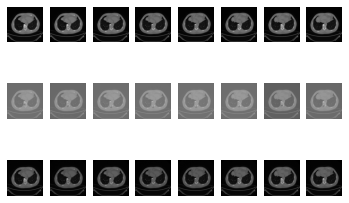

In [ ]:
#-----------------------------------------------------------------------------#
#---------------------------------MAIN LOADING--------------------------------#
#-----------------------------------------------------------------------------#
def main():
    multiprocessing.freeze_support()

    n = input('da che epoca vuoi ripartire? (epoca ultimo modello salvato): ')
    df = pd.read_csv('/content/drive/My Drive/score.csv', header=0)
    olda = df.iloc[int(n)-1, 1]
    oldb = df.iloc[int(n)-1, 3]
    print(olda, oldb)
    # Random seed
    torch.manual_seed(123)

    # Set device
    torch.cuda.empty_cache()

    # Cuda activation
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("cuda")
    else:
        device = torch.device("cpu")
        print("cpu")

    # splitting dataset
    train_split = 0.8
    val_split = 0.2
    test_split = 0.1

    # HYPERPARAMETERS
    # data set
    bs = 8
    # discriminators
    ndf = 64
    # generators
    f = 64
    blocks = 9
    # training loss
    lr = 0.0002
    num_epochs = 10
    discriminators_epochs = 3
    LAMBDA_GP = 10
    Criterion_Im = nn.L1Loss()
    # beta1 = 0.5 #0.9
    # beta2 = 0.999 per adam mett dentro
    

    # Networks' initialization
    nc = 1
    
    D_A = torch.load(path_models+'D_A_epoch{}'.format(n)).to(device=device)
    D_B = torch.load(path_models+'D_B_epoch{}'.format(n)).to(device=device)

    G_A2B = torch.load(path_models+'G_A2B_epoch{}'.format(n)).to(device=device)
    G_B2A = torch.load(path_models+'G_B2A_epoch{}'.format(n)).to(device=device)

    # Parameters' initialization
    optimizer_D_A = torch.optim.Adam(D_A.parameters())
    optimizer_D_B = torch.optim.Adam(D_B.parameters())

    optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(),)
    optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(),)

    optimizer_D_A.load_state_dict(torch.load(path_opt+'opt_D_A_epoch{}'.format(n)))
    optimizer_D_B.load_state_dict(torch.load(path_opt+'opt_D_B_epoch{}'.format(n)))

    optimizer_G_A2B.load_state_dict(torch.load(path_opt+'opt_G_A2B_epoch{}'.format(n)))
    optimizer_G_B2A.load_state_dict(torch.load(path_opt+'opt_G_B2A_epoch{}'.format(n)))

    # DATA PREPARATION
    image_size = (256, 256)
    workers = 0

    dataroot = '/content/drive/My Drive/dataset256uint8/FINAL_DATAct'  # Directory with ct img
    dataset_CT = dset.ImageFolder(root=dataroot, transform=transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0,), (1,)),
    ]))

    dataset_size = len(dataset_CT)


    indices = list(range(dataset_size))
    split1 = int(np.floor(test_split * dataset_size))
    preparation_indices, test_indices = indices[split1:], indices[:split1]
    split2 = int(np.floor(val_split * len(preparation_indices)))
    train_indices, val_indices = preparation_indices[split2:], preparation_indices[:split2]

    print('Training set: ', (len(train_indices)/dataset_size)*100, '%\nValidation set: ', (len(val_indices)/dataset_size)*100, '%\nTest set: ', (len(test_indices)/dataset_size)*100, '%')

    train_dataset_CT = Subset(dataset_CT, train_indices)
    train_loader_CT = torchdata.DataLoader(train_dataset_CT, batch_size=bs, shuffle=True)

    val_dataset_CT = Subset(dataset_CT, val_indices)
    validation_loader_CT = torchdata.DataLoader(val_dataset_CT, batch_size=bs, shuffle=False)

    dataroot = '/content/drive/My Drive/dataset256uint8/FINAL_DATApetct'  # Directory with pet-ct img
    dataset_PT = dset.ImageFolder(root=dataroot, transform=transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0,), (1,)),
    ]))

    train_dataset_PT = Subset(dataset_PT, train_indices)
    train_loader_PT = torchdata.DataLoader(train_dataset_PT, batch_size=bs, shuffle=True)

    val_dataset_PT = Subset(dataset_PT, val_indices)
    validation_loader_PT = torchdata.DataLoader(val_dataset_PT, batch_size=bs, shuffle=False)

    # image loading
    real_batch1=next(iter(train_dataset_CT))
    real_batch2=next(iter(train_dataset_PT))

    for i in range(int(len(real_batch1[0])/8)):
        sample = real_batch1[0][i]
        ax = plt.subplot(1, 8, i + 1)
        ax.axis('off')
        image_viewer(sample)
    plt.show()

    for i in range(int(len(real_batch2[0])/8)):
        sample = real_batch2[0][i]
        ax = plt.subplot(1, 8, i + 1)
        ax.axis('off')
        image_viewer(sample)
    plt.show()

    # TRAINING MODELS
    n_batches_train=len(train_loader_CT)
    n_batches_validation=len(validation_loader_CT)

    Train(num_epochs, discriminators_epochs, n_batches_train, n_batches_validation, G_A2B, G_B2A, optimizer_G_A2B, optimizer_G_B2A,
          D_A, D_B, optimizer_D_A, optimizer_D_B, Criterion_Im, train_loader_CT,
          train_loader_PT, validation_loader_CT, validation_loader_PT, LAMBDA_GP, device, sp=int(n),
          old_score_A=olda, old_score_B=oldb)


if __name__ == '__main__':
    main()


In [ ]:
#-----------------------------------------------------------------------------#
#-------------------------------MAIN PREDICTION-------------------------------#
#-----------------------------------------------------------------------------#
def main():
  # Random seed
  torch.manual_seed(123)

  # Set device
  torch.cuda.empty_cache()

  # Cuda activation
  if torch.cuda.is_available():
      device = torch.device("cuda")
      print("cuda")
  else:
      device = torch.device("cpu")
      print("cpu")

  # splitting dataset
  train_split = 0.8
  validation_split = 0.2
  test_split=0.1

  path_pred='/content/drive/My Drive/prediction1stepoch/'

  # HYPERPARAMETERS
  # data set
  bs = 8

  G_A2B = torch.load(path_models+'G_A2B_epoch1').to(device=device)
  G_B2A = torch.load(path_models+'G_B2A_epoch2').to(device=device)

  # DATA PREPARATION
  image_size = (256, 256)
  workers = 0
  
  dataroot = '/content/drive/My Drive/dataset256uint8/FINAL_DATAct'  # Directory with ct img
  dataset_CT = dset.ImageFolder(root=dataroot, transform=transforms.Compose([
      transforms.Grayscale(),
      transforms.ToTensor(),
      transforms.Normalize((0,), (1,)),
  ]))

  dataset_size = len(dataset_CT)


  indices = list(range(dataset_size))
  split1 = int(np.floor(test_split * dataset_size))
  preparation_indices, test_indices = indices[split1:], indices[:split1]
  
  test_dataset_CT = Subset(dataset_CT, test_indices)
  test_loader_CT = torchdata.DataLoader(test_dataset_CT, batch_size=bs, shuffle=False)

  dataroot = '/content/drive/My Drive/dataset256uint8/FINAL_DATApetct'  # Directory with pet-ct img
  dataset_PT = dset.ImageFolder(root=dataroot, transform=transforms.Compose([
      transforms.Grayscale(),
      transforms.ToTensor(),
      transforms.Normalize((0,), (1,)),
  ]))

  test_dataset_PT = Subset(dataset_PT, test_indices)
  test_loader_PT = torchdata.DataLoader(test_dataset_PT, batch_size=bs, shuffle=False)

  # generate images

  G_A2B.eval()
  G_B2A.eval()
  test_score_A=[]
  test_score_B=[]

  n_batches_test=len(test_loader_CT)

  ITER1=iter(test_loader_CT)
  ITER2=iter(test_loader_PT)
  for i in tqdm(range(n_batches_test)):

    data_CT = next(ITER1)
    data_PT = next(ITER2)

    A_real = data_CT[0].to(device=device)
    B_real = data_PT[0].to(device=device)

    B_fake = G_A2B(A_real)
    A_fake = G_B2A(B_real)

    A_real=A_real.detach().cpu().numpy()    
    A_fake=A_fake.detach().cpu().numpy()
    B_real=B_real.detach().cpu().numpy()    
    B_fake=B_fake.detach().cpu().numpy()

    for k in range(8):
      img = np.squeeze(A_fake[k])
      plt.imsave(path_pred+'CT{}{}.png'.format(i, k),img, cmap=plt.cm.gray)

      img1 = np.squeeze(B_fake[k])
      plt.imsave(path_pred+'PT{}{}.png'.format(i, k),img1, cmap=plt.cm.gray)

    final_score_A, final_score_B = score(A_real, A_fake, B_real, B_fake)

    test_score_A.append(final_score_A)
    test_score_B.append(final_score_B)

  score_A = np.mean(test_score_A)
  score_B = np.mean(test_score_B)
  std_A = np.std(test_score_A)
  std_B = np.std(test_score_B)

  print('CT to PET-CT\tmean: ', score_A, '\tstd: ', std_A)
  print('PET-CT to CT\tmean: ', score_B, '\tstd: ', std_B)

if __name__ == '__main__':
  main()


cuda


100%|█████████▉| 203/204 [36:55<00:10, 10.91s/it]


IndexError: ignored

In [ ]:
def score(imA_real, imA_fake, imB_real, imB_fake):
  simm_CTtoPT_array = []
  simm_PTtoCT_array = []
  for i in range(len(imA_real)):
    imA_real_s=np.squeeze(imA_real[i])
    imA_fake_s=np.squeeze(imA_fake[i])
    imB_real_s=np.squeeze(imB_real[i])
    imB_fake_s=np.squeeze(imB_fake[i])

    simm_CTtoPT_array.append(ssim(imA_real_s[32:224, 32:224], imA_fake_s[32:224, 32:224]))
    simm_PTtoCT_array.append(ssim(imB_real_s[32:224, 32:224], imB_fake_s[32:224, 32:224]))

  simm_CTtoPT = np.mean(simm_CTtoPT_array)
  simm_PTtoCT = np.mean(simm_PTtoCT_array)
  
  #DICE COEFFICIENT
  dice_coeff_array_A=[]
  dice_coeff_array_B=[] 
  for i in range(len(imA_real)):

    maskA_real=get_body_mask(np.squeeze(imA_real[i]))
    maskA_fake=get_body_mask(np.squeeze(imA_fake[i]))
    maskB_real=get_body_mask(np.squeeze(imB_real[i]))
    maskB_fake=get_body_mask(np.squeeze(imB_fake[i]))

    imA_real_final=maskA_real*1.0
    imA_fake_final=maskA_fake*1.0
    imB_real_final=maskB_real*1.0
    imB_fake_final=maskB_fake*1.0
    
    intersection_A = tf.reduce_sum(imA_real_final * imA_fake_final)
    result_A=( (2.* intersection_A + 1)/(K.sum(imA_real_final)+K.sum(imA_fake_final)+1) ).numpy()
    dice_coeff_array_A.append(result_A)

    intersection_B = tf.reduce_sum(imB_real_final * imB_fake_final)
    result_B=( (2.* intersection_B + 1)/(K.sum(imB_real_final)+K.sum(imB_fake_final)+1) ).numpy()
    dice_coeff_array_B.append(result_B)
  

  dice_coeff_A= np.mean(dice_coeff_array_A)
  dice_coeff_B= np.mean(dice_coeff_array_B)

  #print('DICE COEFFICIENT A:', dice_coeff_A)
  #print('DICE COEFFICIENT B:', dice_coeff_B)

  score_A=0.85*simm_CTtoPT+0.15*dice_coeff_A
  score_B=0.85*simm_PTtoCT+0.15*dice_coeff_B
  return score_A, score_B
  
  del maskA_real, maskB_real, maskA_fake, maskB_fake, imA_real_final, imA_fake_final, imB_fake_final, imB_real_final, dice_coeff_array_A, dice_coeff_array_B, intersection_A, result_A, intersection_B, result_B
  torch.cuda.empty_cache()
<



dataroot = '/content/drive/My Drive/dataset256uint8/FINAL_DATAct'  # Directory with ct img
dataset_CT = dset.ImageFolder(root=dataroot, transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),
]))

dataset_size = len(dataset_CT)


indices = list(range(500))
split1 = int(np.floor(0.1 * dataset_size))
preparation_indices, test_indices = indices[split1:], indices[:split1]
test_dataset_CT = Subset(dataset_CT, test_indices)
test_loader_CT = torchdata.DataLoader(test_dataset_CT, batch_size=8, shuffle=False)

dataroot = '/content/drive/My Drive/dataset256uint8/FINAL_DATApetct'  # Directory with pet-ct img
dataset_PT = dset.ImageFolder(root=dataroot, transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),
]))

test_dataset_PT = Subset(dataset_PT, test_indices)
test_loader_PT = torchdata.DataLoader(test_dataset_PT, batch_size=8, shuffle=False)

ITER1=iter(test_loader_CT)
ITER2=iter(test_loader_PT)
data_CT = next(ITER1)
data_PT = next(ITER2)
A_real=data_CT[0].detach().cpu().numpy()
B_real=data_PT[0].detach().cpu().numpy()


scoreA, scoreB=score(A_real, B_real, A_real, B_real)
print('CT to PET-CT\tmean: ', scoreA)
print('PET-CT to CT\tmean: ', scoreB)